In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import IPython

In [2]:
## Read data dari github
data = pd.read_csv('https://raw.githubusercontent.com/novra/dts_sosmed8/main/tweets.csv')
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


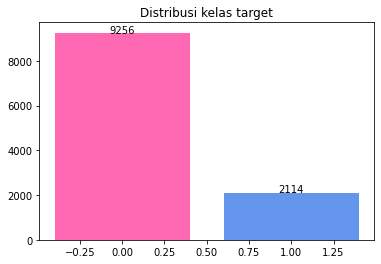

In [3]:
# Menghitung jumlah masing-masing target
target = list(set(data['target']))
jumlah_target = []
for i in target:
  jumlah_target.append(list(data['target']).count(i))

#visualisasi jumlah keyword
warna = np.array(['hotpink', 'cornflowerblue'])
plt.bar(target, jumlah_target, color=warna)
plt.title("Distribusi kelas target")
## Menampilkan label pada grafik
for i in range(len(target)):
    plt.text(i, jumlah_target[i], jumlah_target[i], ha = 'center')

plt.show()

In [4]:
## mendefinisikan fungsi untuk clean data
def clean_data(teks):
    # Mengubah semua huruf menjadi huruf kecil
    teks = teks.lower()
    # Menghapus www.* atau https?://*
    teks = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',teks)
    # Menghapus tanda #
    teks = re.sub(r'#([^\s]+)', r'\1', teks)
    # Menghapus tanda baca
    teks = re.sub(r'[^\w\s]',' ', teks)
    # Menghapus angka
    teks = re.sub(r'[\d-]', '', teks)
    # Menghapus spasi berlebih
    teks = re.sub('[\s]+', ' ', teks)
    # Menghapus tanda \, ', dan "
    teks = teks.strip('\'"')
    
    # Pembersihan kata
    words = teks.split()
    tokens=[]
    for ww in words:
        # Memisahkan kata berulang
        for w in re.split(r'[-/\s]\s*', ww):
            # Menghapus huruf berulang yang lebih dari dua kali
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            w = pattern.sub(r"\1\1", w)
            w = w.strip('\'"?,.')
            # Memeriksa apakah suatu kata terbentuk dari minimal dua huruf
            val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
            if w == "rt" or val is None:
                continue
            else:
                tokens.append(w.lower())
    
    teks = " ".join(tokens)  
    return teks

# clean data teks
data['text'] = data['text'].map(lambda x: clean_data(x))
teks = data[data['text'].apply(lambda x: len(x.split()) >=1)]
teks = np.array(data['text'])

#One hot encoding pada data target
target = np.array(pd.get_dummies(data['target']))

In [5]:
# Pemisahan data training & data testing
data_train,data_test,label_train,label_test = train_test_split(teks, target, test_size=0.2,
                                                               stratify=target, random_state=7)

In [6]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('cross-encoder/ms-marco-TinyBERT-L-2-v2')
bert_model = TFBertModel.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2", trainable=False, from_pt=True)

2022-07-26 16:11:42.344790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:11:42.345869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:11:42.346531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:11:42.348357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/787 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
# Pendefinisian fungsi untuk melakukan tokenisasi pada satu data
def tokenisasi(teks):
      encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 80,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

      tokenID = encode_dict['input_ids']
      attention_mask = encode_dict['attention_mask']

      return tokenID, attention_mask

# Pendefinisian fungsi untuk mengambil hasil tokenisasi pada semua data
def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)
    
    return {'input_ids': np.asarray(tokenID, dtype=np.int32).reshape(-1, 80), 
            'attention_mask': np.asarray(input_mask, dtype=np.int32).reshape(-1, 80)}

In [8]:
# Membuat tokenID untuk X_train dan X_test
X_train = create_input(data_train)
X_test = create_input(data_test)

#Mengambil representasi teks dari encoder layer ke 12 dari model BERT
X_train = bert_model(**X_train)[0]
X_test = bert_model(**X_test)[0]

In [9]:
from keras_tuner.tuners import BayesianOptimization
#Mendefinisikan fungsi untuk klasifikasi dengan model hybrid CNN-GRU menggunakan beberapa kandidat hyperparameter
def cnn_gru(hp):
    #Input layer
    input = keras.layers.Input(shape=(80, 128))

    #Convolution layer
    cnn = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.01, 0.001])))(input)

    #Max Pooling layer
    maxpool = keras.layers.MaxPooling1D(pool_size=2)(cnn)

    #GRU layer
    gru = keras.layers.GRU(units = hp.Int('units',
                                             min_value = 100,
                                             max_value = 200,
                                             step = 50),
                                      kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                         values = [0.01, 0.001])),
                                      recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                            values = [0.01, 0.001])))(maxpool)
    #Output layer
    output = keras.layers.Dense(2, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.01, 0.001])))(gru)
    model = keras.models.Model(inputs=input, outputs=output)

    model.compile(optimizer = keras.optimizers.Adam(1e-3),
                  loss ='categorical_crossentropy',
                  metrics=['accuracy'])
   
    return model

# Pendefinisian Callback
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Hyperparameter tuning menggunakan bayesian optimization dengan
#banyak percobaan kombinasi hyperparameter sebanyak 10
tuner = BayesianOptimization(cnn_gru,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = '/content/Hasil',
                             project_name = 'Sentimen-CNN-GRU',
                             overwrite = True)

tuner.search(X_train, label_train,
             batch_size=64, epochs=50,
             validation_data=(X_test, label_test),
             callbacks=[early_stop, ClearTrainingOutput()])

# Mendapatkan model terbaik dari 10 percobaan bayesian
model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 29s]
val_accuracy: 0.8812664747238159

Best val_accuracy So Far: 0.8861038088798523
Total elapsed time: 00h 05m 46s


In [10]:
# Retrain model pada data test
history = model.fit(X_train, label_train,
                    batch_size=32, epochs=50,
                    validation_data=(X_test, label_test),
                    callbacks=[early_stop])

Epoch 1/50
285/285 [==============================] - 4s 9ms/step - loss: 0.3473 - accuracy: 0.8772 - val_loss: 0.3484 - val_accuracy: 0.8720
Epoch 2/50
285/285 [==============================] - 2s 8ms/step - loss: 0.3293 - accuracy: 0.8804 - val_loss: 0.3875 - val_accuracy: 0.8421
Epoch 3/50
285/285 [==============================] - 2s 7ms/step - loss: 0.3129 - accuracy: 0.8850 - val_loss: 0.3306 - val_accuracy: 0.8852
Epoch 4/50
285/285 [==============================] - 2s 7ms/step - loss: 0.3089 - accuracy: 0.8871 - val_loss: 0.3291 - val_accuracy: 0.8764
Epoch 5/50
285/285 [==============================] - 2s 7ms/step - loss: 0.3033 - accuracy: 0.8916 - val_loss: 0.3584 - val_accuracy: 0.8650
Epoch 6/50
285/285 [==============================] - 2s 7ms/step - loss: 0.2934 - accuracy: 0.8917 - val_loss: 0.3428 - val_accuracy: 0.8659
Epoch 7/50
285/285 [==============================] - 2s 7ms/step - loss: 0.2899 - accuracy: 0.8980 - val_loss: 0.3370 - val_accuracy: 0.8716
Epoch 

In [11]:
# Mendapatkan kinerja model
y_pred = np.argmax(model.predict(X_test), axis=1)
y = np.argmax(label_test, axis=1)
print('accuracy: ', accuracy_score(y, y_pred),
      '\nprecicion: ', precision_score(y, y_pred),
      '\nrecall: ', recall_score(y, y_pred))

accuracy:  0.8711521547933158 
precicion:  0.6525821596244131 
recall:  0.6572104018912529


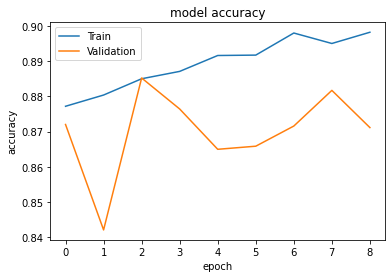

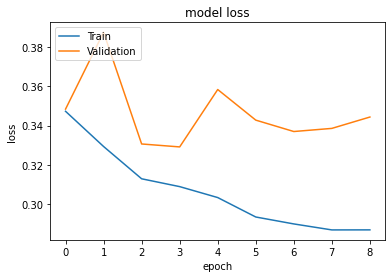

In [12]:
# plot grafik akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot grafik loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()